# Medium_range National Water Model Forecast
### Workflow for creating a 10-day (no ensemble members) or 8.5-day (with ensemble members) streamflow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [1]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
from scipy.interpolate import interp1d

%matplotlib inline

## Set up the Google Cloud File System

In [2]:
fs = gcsfs.GCSFileSystem(project='national-water-model')

# Set the parameters

In [3]:
date = '20190730' # a date
start_time = '00' # start at 00:00 because its easy at the moment
# comid = 4512772 # some small segment on the Potomac near DC
comid = 229757 # the South Platte River in Denver

## Open all netcdf files of interest, concat them into an xarray multifile dataset -- **_1 for each member_**

- This step takes longer than expected due to reading from GCS over the internet

#### Prior to June 2019, there was only one medium range forecast, not 7 members. The if/else accounts for that but can most likely be removed in the future

In [4]:
datepath = f'national-water-model/nwm.{date}'
if 'medium_range_mem' in str(fs.ls(datepath)): 
    xr_datasets = []
    multi_mem = True
    len_forecast = '8.5-day'
    for i in range(1,8): # ensemble members
        mem = str(i)
        open_ncdfs = []
        for i in range(3, 205, 3): # for times 3-240 or 3-204 in steps of 3
            hr = str(i).zfill(3)
            filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt_{mem}.f{hr}.conus.nc'
            file = fs.open(filepath, 'rb')
            open_ncdfs.append(file)
        mfdset = xr.open_mfdataset(open_ncdfs)
        xr_datasets.append(mfdset)

else:
    multi_mem = False
    len_forecast = '10-day'
    open_ncdfs = []
    for i in range(3, 241, 3): # for times 3-240 or 3-204 in steps of 3
        hr = str(i).zfill(3)
        filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt.f{hr}.conus.nc'
        file = fs.open(filepath, 'rb')
        open_ncdfs.append(file)
    mfdset = xr.open_mfdataset(open_ncdfs)
    
print(f'Multi-member: {multi_mem}')

Multi-member: True


## Pull the data from each multifile xarray dataset, make a list of dictionaries

In [5]:
outjson = []
for ds in xr_datasets:
    output_da = ds.sel(feature_id=comid)['streamflow']
    times = output_da['time'].values.astype(str)
    arr = output_da.values
    d = {}
    d[ds.attrs['ensemble_member_number']] = dict(zip(times, arr))
    outjson.append(d)

## Dump them into a pandas dataframe

In [6]:
df = pd.concat([pd.read_json(json.dumps(x), orient='index') for x in outjson]).T
df['mean'] = df.mean(axis=1)
df.head()

,1,2,3,4,5,6,7,mean
2019-07-30 03:00:00,10.55,10.55,10.55,10.55,10.55,10.55,10.55,10.550000
2019-07-30 06:00:00,10.68,10.67,10.67,10.67,10.67,10.67,10.67,10.671428
2019-07-30 09:00:00,10.75,10.75,10.74,10.75,10.75,10.75,10.75,10.748571
2019-07-30 12:00:00,9.87,9.87,9.87,9.87,9.87,9.87,9.87,9.870000
2019-07-30 15:00:00,8.38,8.38,8.37,8.37,8.37,8.37,8.37,8.372857


## Stats

In [7]:
stats = df.T.describe()
stats

,2019-07-30 03:00:00,2019-07-30 06:00:00,2019-07-30 09:00:00,2019-07-30 12:00:00,2019-07-30 15:00:00,2019-07-30 18:00:00,2019-07-30 21:00:00,2019-07-31 00:00:00,2019-07-31 03:00:00,2019-07-31 06:00:00,...,2019-08-06 09:00:00,2019-08-06 12:00:00,2019-08-06 15:00:00,2019-08-06 18:00:00,2019-08-06 21:00:00,2019-08-07 00:00:00,2019-08-07 03:00:00,2019-08-07 06:00:00,2019-08-07 09:00:00,2019-08-07 12:00:00
count,8.00,8.000000,8.000000,8.00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000
mean,10.55,10.671428,10.748571,9.87,8.372857,7.011428,6.334286,6.610000,7.494286,7.431428,...,11.155714,13.420000,13.360000,11.637143,9.982857,9.95000,12.145714,13.890000,15.208571,16.274285
std,0.00,0.003499,0.003499,0.00,0.004518,0.003499,0.129599,0.652205,2.104138,2.144691,...,4.314934,4.872705,3.956911,2.706182,1.822022,1.26222,2.927270,4.339457,5.312810,6.683529
min,10.55,10.670000,10.740000,9.87,8.370000,7.010000,6.220000,5.840000,5.670000,5.670000,...,6.000000,6.190000,6.470000,6.710000,7.240000,8.16000,8.450000,8.190000,8.080000,8.190000
25%,10.55,10.670000,10.749643,9.87,8.370000,7.010000,6.235000,6.202500,6.157500,6.002500,...,7.990000,11.047500,11.482500,10.512500,9.022500,9.34750,9.630000,10.955000,12.530000,13.505000
50%,10.55,10.670000,10.750000,9.87,8.370000,7.010000,6.302143,6.425000,6.545000,6.405000,...,10.627857,12.410000,12.870000,11.483571,9.946428,9.86500,11.912857,13.470000,14.584285,15.132143
75%,10.55,10.670357,10.750000,9.87,8.374643,7.010357,6.387500,6.862500,8.098214,8.186071,...,13.162500,15.027500,16.377500,13.352500,10.897500,10.41750,14.507500,15.970000,16.175000,17.152500
max,10.55,10.680000,10.750000,9.87,8.380000,7.020000,6.600000,7.610000,11.520000,11.120000,...,17.480000,21.010000,18.170000,15.320000,12.970000,12.29000,16.320000,21.910000,25.859999,31.089999


## Plot the stream flow and the statistics

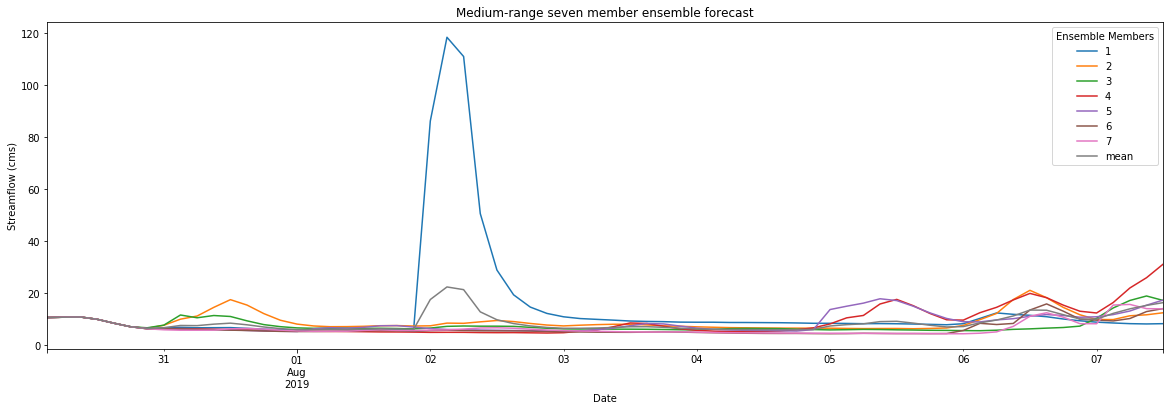

In [8]:
ax = df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

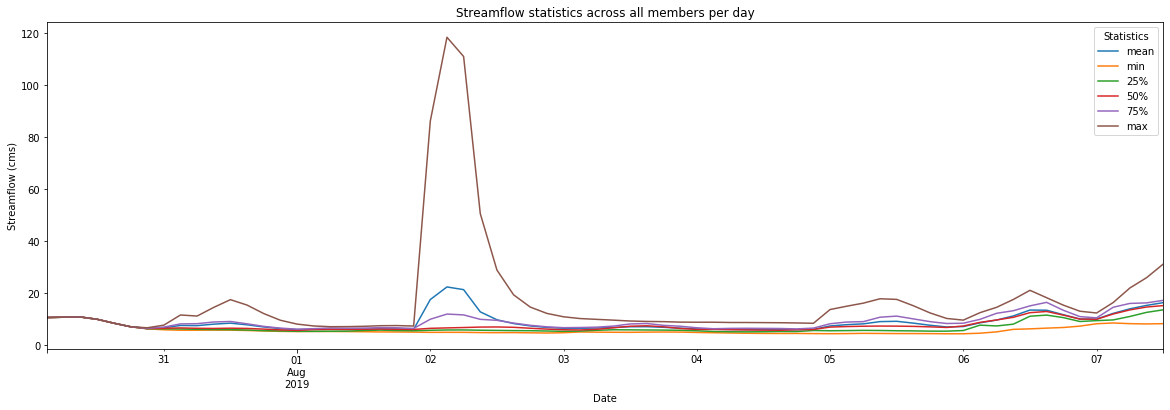

In [9]:
ax = stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

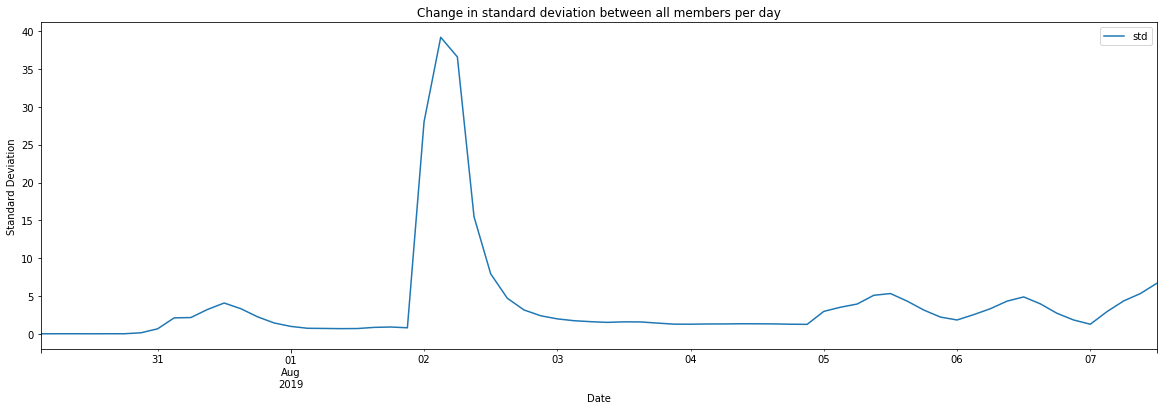

In [10]:
ax = stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.set(xlabel='Date', ylabel='Standard Deviation');

# Convert Flow to Stage

In [11]:
ds = xr.open_dataset(r'C:\Data\fcast_data\hydroprop-fulltable2D.nc')
dis_ds = ds.Discharge.sel(CatchId=comid)
dis_df = dis_ds.to_dataframe().reset_index().drop(columns=['CatchId'])

In [12]:
df.head()

,1,2,3,4,5,6,7,mean
2019-07-30 03:00:00,10.55,10.55,10.55,10.55,10.55,10.55,10.55,10.550000
2019-07-30 06:00:00,10.68,10.67,10.67,10.67,10.67,10.67,10.67,10.671428
2019-07-30 09:00:00,10.75,10.75,10.74,10.75,10.75,10.75,10.75,10.748571
2019-07-30 12:00:00,9.87,9.87,9.87,9.87,9.87,9.87,9.87,9.870000
2019-07-30 15:00:00,8.38,8.38,8.37,8.37,8.37,8.37,8.37,8.372857


In [13]:
dis_df.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,3.033997
2,0.6096,10.762421
3,0.9144,22.444401
4,1.2192,37.477618


## Make an interpolation function to convert from streamflow to stage based on the rating curve provided by the NWM

In [14]:
f = interp1d(dis_df.Discharge, dis_df.Stage, kind='cubic')
stage_df = df.apply(f)
stage_stats = stage_df.T.describe()

## Plot the forecasted stage depth

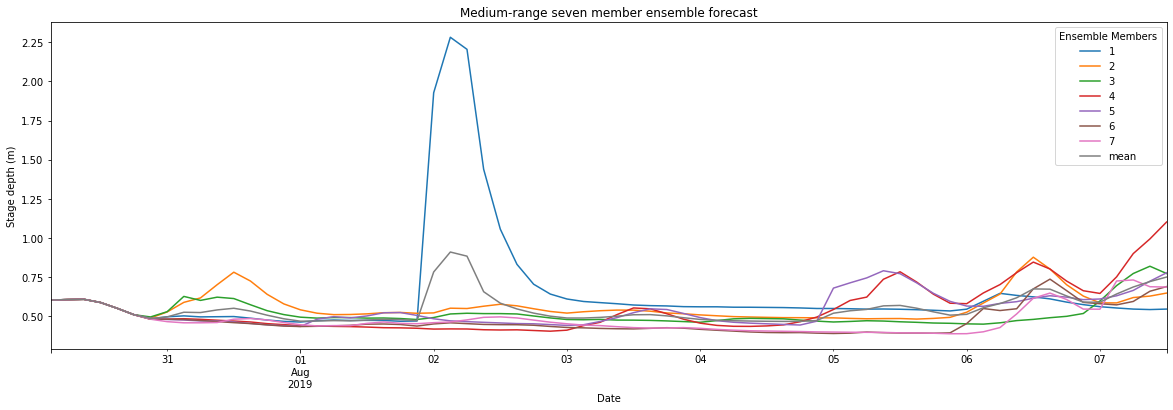

In [15]:
ax = stage_df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.set(xlabel='Date', ylabel='Stage depth (m)');

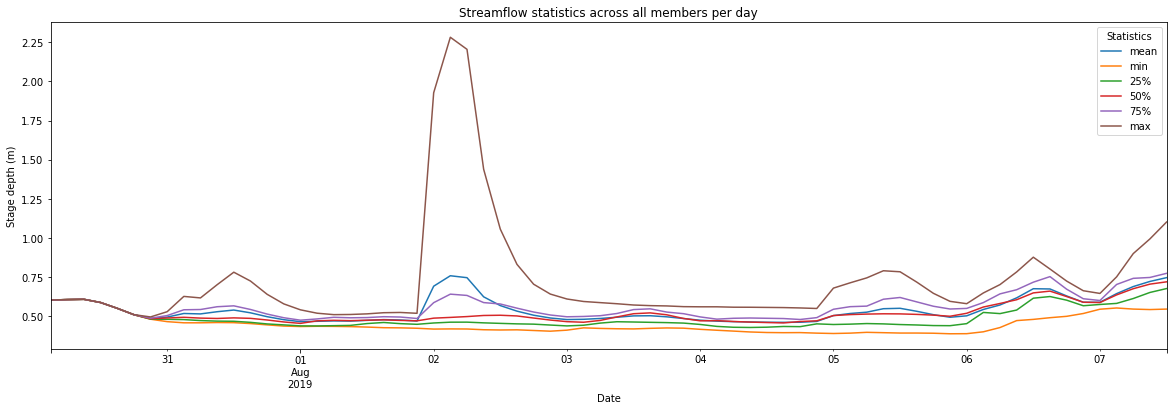

In [16]:
ax = stage_stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.set(xlabel='Date', ylabel='Stage depth (m)');

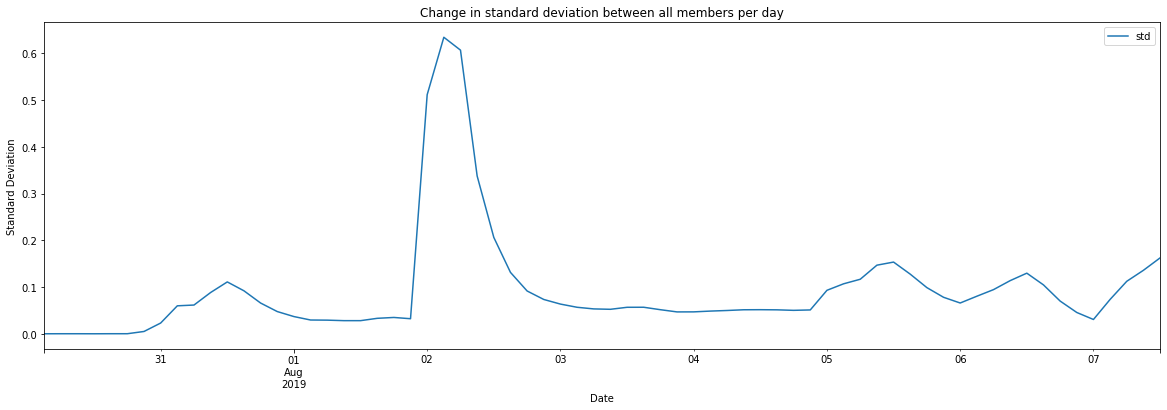

In [17]:
ax = stage_stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.set(xlabel='Date', ylabel='Standard Deviation');